In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyqtgraph.Qt import QtGui, QtCore
import pyqtgraph as pg
from itertools import cycle

In [2]:
# Generate landmarks

num_lm = 10

theta = np.linspace(np.pi/2, np.pi, num_lm)
lm_x = (50 * np.cos(theta)) + np.random.normal(size=num_lm) + 40
lm_y = (50 * np.sin(theta)) + np.random.normal(size=num_lm) + 50
lm_x = np.append(lm_x, np.linspace(0, 0, num_lm) + np.random.normal(size=num_lm) - 10)
lm_y = np.append(lm_y, np.linspace(0, 50, num_lm) + np.random.normal(size=num_lm))

num_path = 30
gt_path_x = np.linspace(0, 0, num_path)
gt_path_y = np.linspace(0, 50, num_path) 
theta = np.linspace(np.pi/2, np.pi, num_path)
gt_path_x = np.append(gt_path_x, np.sort((40 * np.cos(theta)) + 40))
gt_path_y = np.append(gt_path_y, np.sort((40 * np.sin(theta)) + 50))
gt_path_dx = np.ediff1d(gt_path_x, to_begin=0)
gt_path_dy = np.ediff1d(gt_path_y, to_begin=0)
gt_path_yaw = np.arctan2(gt_path_dx, gt_path_dy) * (180/np.pi)

gt_path = np.vstack([gt_path_x, gt_path_y, gt_path_yaw])

In [3]:
def path_gen(path):
    for idx in cycle(range(path.shape[1])):
        yield path[:,idx].reshape(-1, 1)

In [ ]:
lm_x = lm_x.reshape(1, -1)
lm_y = lm_y.reshape(1, -1)
gt_wf_lm = np.vstack([lm_x, lm_y, np.ones(lm_x.shape)])

In [ ]:
class Transform:
    def __init__(self, theta_deg=0, x_off=0, y_off=0):
        self.update_tf(theta_deg, x_off, y_off)
        
    def __repr__(self):
        return np.array_repr(self.tf)
    
    def __str__(self):
        return np.array_repr(self.tf)
    
    def update_tf(self, theta_deg, x_off, y_off):
        self.x_off, self.y_off = x_off, y_off
        self.theta_rad = -theta_deg * (np.pi / 180)
        tr = self.theta_rad
        self.tf = np.array([[np.cos(tr), -np.sin(tr), self.x_off],
                            [np.sin(tr), np.cos(tr),  self.y_off],
                            [0,          0,           1]])
        self.inv_tf = np.linalg.inv(self.tf)
    
    def get_tf_array(self):
        return self.tf
    
    def apply_tf_to_pts(self, input_pts):
        """
        Applies the transfomation to the points such that result = tf @ input
        """
        result_pts = self.tf @ input_pts 
        return result_pts
    
    def apply_inv_tf_to_pts(self, result_pts):
        input_pts = self.inv_tf @ result_pts
        return input_pts

gt_wf_to_vf_tf = Transform(theta_deg=0, x_off=0)
gt_vf_to_sf_tf = Transform(theta_deg=0, x_off=1, y_off=1)
err_vf_to_sf_tf = Transform(theta_deg=0, x_off=5, y_off=1)

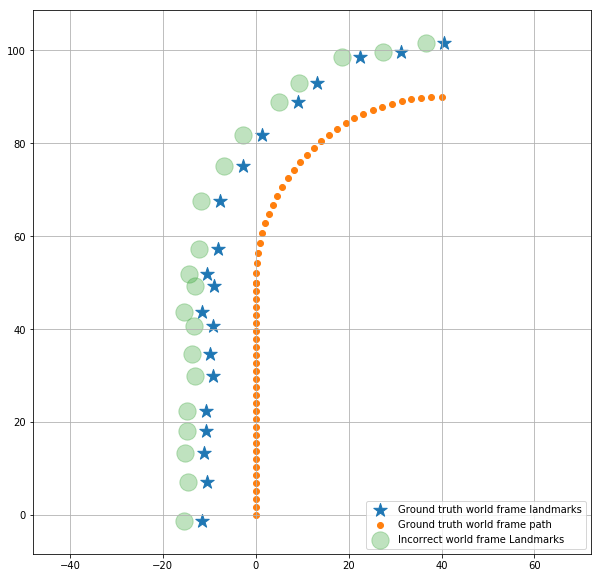

In [ ]:
# Put points into sensor frame correctly
gt_vf_lm = gt_wf_to_vf_tf.apply_tf_to_pts(gt_wf_lm)
gt_sf_lm = gt_vf_to_sf_tf.apply_tf_to_pts(gt_vf_lm)
err_vf_lm = err_vf_to_sf_tf.apply_inv_tf_to_pts(gt_sf_lm)
err_world_lm = gt_wf_to_vf_tf.apply_inv_tf_to_pts(err_vf_lm)


# plots
plt.figure(figsize=(10,10))
plt.scatter(gt_wf_lm[0,:], gt_wf_lm[1,:], marker='*', s=200, label='Ground truth world frame landmarks')
plt.scatter(gt_path_x, gt_path_y, label="Ground truth world frame path")
plt.scatter(err_world_lm[0,:], err_world_lm[1,:], s=300, alpha=0.3, label='Incorrect world frame Landmarks')
plt.grid()
plt.axis('equal')
plt.legend(loc='lower right')
plt.show()

In [ ]:
app = QtGui.QApplication([])
mw = QtGui.QMainWindow()
mw.resize(800,800)
view = pg.GraphicsLayoutWidget()  ## GraphicsView with GraphicsLayout inserted by default
#view.setRange(xRange=[-50, 110], yRange=[-50, 110])
mw.setCentralWidget(view)
mw.show()
mw.setWindowTitle('Sensor Calibration Error Demonstration')

w1 = view.addPlot()
#w1.setXRange(min=-30, max=110, padding=0)
#w1.setYRange(min=-30, max=110, padding=0)
gt_lm_pi = pg.ScatterPlotItem(pen='r')
gt_lm_pi.setSymbol('+')
gt_lm_pi.setData(pos=gt_wf_lm.T)
w1.addItem(gt_lm_pi)

veh_orig_pi = pg.ScatterPlotItem(pen='g')
gen = path_gen(gt_path)

s1 = pg.ScatterPlotItem(pen='w')

def update():
    w1.removeItem(veh_orig_pi)
    #w1.removeItem(s1)
    
    cur_pos = next(gen)
    veh_orig_pi.setData(pos=cur_pos[:2].T)
    w1.addItem(veh_orig_pi)
    
    print(f"Theta = {cur_pos[2, 0]}, x_off = {cur_pos[0, 0]}, y_off = {cur_pos[1, 0]}")
    gt_wf_to_vf_tf = Transform(theta_deg=cur_pos[2, 0], x_off=cur_pos[0, 0], y_off=cur_pos[1, 0])
    gt_vf_to_sf_tf = Transform(theta_deg=0, x_off=1, y_off=1)
    err_vf_to_sf_tf = Transform(theta_deg=1, x_off=1, y_off=1)
    
    gt_vf_lm = gt_wf_to_vf_tf.apply_tf_to_pts(gt_wf_lm)
    gt_sf_lm = gt_vf_to_sf_tf.apply_tf_to_pts(gt_vf_lm)
    err_vf_lm = err_vf_to_sf_tf.apply_inv_tf_to_pts(gt_sf_lm)
    err_world_lm = gt_wf_to_vf_tf.apply_inv_tf_to_pts(err_vf_lm)
    
    s1.addPoints(pos=err_world_lm.T)
    w1.addItem(s1)
    
timer = QtCore.QTimer()
timer.timeout.connect(update)
timer.start(100)

QtGui.QApplication.instance().exec_()

Theta = 0.0, x_off = 0.0, y_off = 0.0
Theta = 0.0, x_off = 0.0, y_off = 1.7241379310344827
Theta = 0.0, x_off = 0.0, y_off = 3.4482758620689653
Theta = 0.0, x_off = 0.0, y_off = 5.172413793103448
Theta = 0.0, x_off = 0.0, y_off = 6.896551724137931
Theta = 0.0, x_off = 0.0, y_off = 8.620689655172413
Theta = 0.0, x_off = 0.0, y_off = 10.344827586206897
Theta = 0.0, x_off = 0.0, y_off = 12.068965517241379
Theta = 0.0, x_off = 0.0, y_off = 13.793103448275861
Theta = 0.0, x_off = 0.0, y_off = 15.517241379310343
Theta = 0.0, x_off = 0.0, y_off = 17.241379310344826
Theta = 0.0, x_off = 0.0, y_off = 18.96551724137931
Theta = 0.0, x_off = 0.0, y_off = 20.689655172413794
Theta = 0.0, x_off = 0.0, y_off = 22.413793103448274
Theta = 0.0, x_off = 0.0, y_off = 24.137931034482758
Theta = 0.0, x_off = 0.0, y_off = 25.86206896551724
Theta = 0.0, x_off = 0.0, y_off = 27.586206896551722
Theta = 0.0, x_off = 0.0, y_off = 29.310344827586206
Theta = 0.0, x_off = 0.0, y_off = 31.034482758620687
Theta = 0.0, 

Theta = 0.0, x_off = 0.0, y_off = 15.517241379310343
Theta = 0.0, x_off = 0.0, y_off = 17.241379310344826
Theta = 0.0, x_off = 0.0, y_off = 18.96551724137931
Theta = 0.0, x_off = 0.0, y_off = 20.689655172413794
Theta = 0.0, x_off = 0.0, y_off = 22.413793103448274
Theta = 0.0, x_off = 0.0, y_off = 24.137931034482758
Theta = 0.0, x_off = 0.0, y_off = 25.86206896551724
Theta = 0.0, x_off = 0.0, y_off = 27.586206896551722
Theta = 0.0, x_off = 0.0, y_off = 29.310344827586206
Theta = 0.0, x_off = 0.0, y_off = 31.034482758620687
Theta = 0.0, x_off = 0.0, y_off = 32.75862068965517
Theta = 0.0, x_off = 0.0, y_off = 34.48275862068965
Theta = 0.0, x_off = 0.0, y_off = 36.206896551724135
Theta = 0.0, x_off = 0.0, y_off = 37.93103448275862
Theta = 0.0, x_off = 0.0, y_off = 39.6551724137931
Theta = 0.0, x_off = 0.0, y_off = 41.37931034482759
Theta = 0.0, x_off = 0.0, y_off = 43.103448275862064
Theta = 0.0, x_off = 0.0, y_off = 44.82758620689655
Theta = 0.0, x_off = 0.0, y_off = 46.55172413793103
The

Theta = 0.0, x_off = 0.0, y_off = 29.310344827586206
Theta = 0.0, x_off = 0.0, y_off = 31.034482758620687
Theta = 0.0, x_off = 0.0, y_off = 32.75862068965517
Theta = 0.0, x_off = 0.0, y_off = 34.48275862068965
Theta = 0.0, x_off = 0.0, y_off = 36.206896551724135
Theta = 0.0, x_off = 0.0, y_off = 37.93103448275862
Theta = 0.0, x_off = 0.0, y_off = 39.6551724137931
Theta = 0.0, x_off = 0.0, y_off = 41.37931034482759
Theta = 0.0, x_off = 0.0, y_off = 43.103448275862064
Theta = 0.0, x_off = 0.0, y_off = 44.82758620689655
Theta = 0.0, x_off = 0.0, y_off = 46.55172413793103
Theta = 0.0, x_off = 0.0, y_off = 48.275862068965516
Theta = 0.0, x_off = 0.0, y_off = 50.0
Theta = 0.0, x_off = 0.0, y_off = 50.00000000000001
Theta = 1.5517241379310993, x_off = 0.05866344595504813, y_off = 52.16555634341672
Theta = 4.655172413793063, x_off = 0.2344817138256161, y_off = 54.32476073695768
Theta = 7.758620689655285, x_off = 0.526939098338957, y_off = 56.471279862110585
Theta = 10.862068965517189, x_off = 

Theta = 0.0, x_off = 0.0, y_off = 44.82758620689655
Theta = 0.0, x_off = 0.0, y_off = 46.55172413793103
Theta = 0.0, x_off = 0.0, y_off = 48.275862068965516
Theta = 0.0, x_off = 0.0, y_off = 50.0
Theta = 0.0, x_off = 0.0, y_off = 50.00000000000001
Theta = 1.5517241379310993, x_off = 0.05866344595504813, y_off = 52.16555634341672
Theta = 4.655172413793063, x_off = 0.2344817138256161, y_off = 54.32476073695768
Theta = 7.758620689655285, x_off = 0.526939098338957, y_off = 56.471279862110585
Theta = 10.862068965517189, x_off = 0.9351777715965355, y_off = 58.59881760844097
Theta = 13.965517241379274, x_off = 1.458000299231081, y_off = 60.70113354116883
Theta = 17.068965517241487, x_off = 2.0938731526879053, y_off = 62.77206120543919
Theta = 20.172413793103367, x_off = 2.840931207328346, y_off = 64.80552621359658
Theta = 23.27586206896551, x_off = 3.6969832131617224, y_off = 66.79556406241059
Theta = 26.379310344827513, x_off = 4.659518222159086, y_off = 68.73633762799162
Theta = 29.48275862

Theta = 10.862068965517189, x_off = 0.9351777715965355, y_off = 58.59881760844097
Theta = 13.965517241379274, x_off = 1.458000299231081, y_off = 60.70113354116883
Theta = 17.068965517241487, x_off = 2.0938731526879053, y_off = 62.77206120543919
Theta = 20.172413793103367, x_off = 2.840931207328346, y_off = 64.80552621359658
Theta = 23.27586206896551, x_off = 3.6969832131617224, y_off = 66.79556406241059
Theta = 26.379310344827513, x_off = 4.659518222159086, y_off = 68.73633762799162
Theta = 29.482758620689847, x_off = 5.72571295329643, y_off = 70.62215428708086
Theta = 32.58620689655158, x_off = 6.89244007372438, y_off = 72.4474826144953
Theta = 35.689655172413794, x_off = 8.156277371774252, y_off = 74.20696860775061
Theta = 38.793103448275886, x_off = 9.513517794894547, y_off = 75.89545139127311
Theta = 41.89655172413811, x_off = 10.960180323074766, y_off = 77.50797835413692
Theta = 45.0, x_off = 12.492021645863076, y_off = 79.03981967692523
Theta = 48.10344827586194, x_off = 14.10454